In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import find_highest_wf
from ic_course_utils import replace_tag

%matplotlib inline

In [2]:
input_file = "data/HEe_fastsim.nexus.h5"
#input_file = "data/Kr83_fastsim.nexus.h5"

# Input file structure

The input file contains 1 group (`MC`) and five nodes (`configuration`, `hits`, `particles`, `sns_positions` and `sns_response`). However, the tables `sns_positions` and `sns_response` are empty.

In [3]:
!ptdump $input_file

/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(32,)) ''
/MC/hits (Table(4924,)) ''
/MC/particles (Table(335,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''


The `configuration` node contains a table with the nexus configuration. Each row is a pair of (parameter name | nexus command, value).

In [4]:
!ptdump -vd $input_file:/MC/configuration

/MC/configuration (Table(32,)) ''
  description := {
  "param_key": StringCol(itemsize=300, shape=(), dflt=b'', pos=0),
  "param_value": StringCol(itemsize=300, shape=(), dflt=b'', pos=1)}
  byteorder := 'irrelevant'
  chunkshape := (32768,)
  Data dump:
[0] (b'event_type', b'other')
[1] (b'num_events', b'10')
[2] (b'saved_events', b'10')
[3] (b'interacting_events', b'10')
[4] (b'/PhysicsList/RegisterPhysics', b'G4EmStandardPhysics_option4')
[5] (b'/PhysicsList/RegisterPhysics', b'G4DecayPhysics')
[6] (b'/PhysicsList/RegisterPhysics', b'G4RadioactiveDecayPhysics')
[7] (b'/PhysicsList/RegisterPhysics', b'NexusPhysics')
[8] (b'/PhysicsList/RegisterPhysics', b'G4StepLimiterPhysics')
[9] (b'/nexus/RegisterGeometry', b'NextNew')
[10] (b'/nexus/RegisterGenerator', b'SingleParticleGenerator')
[11] (b'/nexus/RegisterPersistencyManager', b'PersistencyManager')
[12] (b'/nexus/RegisterTrackingAction', b'DefaultTrackingAction')
[13] (b'/nexus/RegisterEventAction', b'DefaultEventAction')
[14] (b'/n

The `hits` node contains a table describing the energy depositions in the active volume (a.k.a. hits). Each hit is described by a x,y,z position in mm, a time in ns, the deposited energy in MeV, the label of the volume where it was produced and an id number that identifies it uniquely within the collection of hits produced by a particle.

In [5]:
!ptdump -v $input_file:/MC/hits

/MC/hits (Table(4924,)) ''
  description := {
  "event_id": Int64Col(shape=(), dflt=0, pos=0),
  "x": Float32Col(shape=(), dflt=0.0, pos=1),
  "y": Float32Col(shape=(), dflt=0.0, pos=2),
  "z": Float32Col(shape=(), dflt=0.0, pos=3),
  "time": Float32Col(shape=(), dflt=0.0, pos=4),
  "energy": Float32Col(shape=(), dflt=0.0, pos=5),
  "label": StringCol(itemsize=100, shape=(), dflt=b'', pos=6),
  "particle_id": Int32Col(shape=(), dflt=0, pos=7),
  "hit_id": Int32Col(shape=(), dflt=0, pos=8)}
  byteorder := 'little'
  chunkshape := (32768,)


The `particles` node contains a table with information about all the particles that were tracked in the simulation (except for optical photons and ionization electrons).

In [6]:
!ptdump -v $input_file:/MC/particles

/MC/particles (Table(335,)) ''
  description := {
  "event_id": Int64Col(shape=(), dflt=0, pos=0),
  "particle_id": Int32Col(shape=(), dflt=0, pos=1),
  "particle_name": StringCol(itemsize=100, shape=(), dflt=b'', pos=2),
  "primary": Int8Col(shape=(), dflt=0, pos=3),
  "mother_id": Int32Col(shape=(), dflt=0, pos=4),
  "initial_x": Float32Col(shape=(), dflt=0.0, pos=5),
  "initial_y": Float32Col(shape=(), dflt=0.0, pos=6),
  "initial_z": Float32Col(shape=(), dflt=0.0, pos=7),
  "initial_t": Float32Col(shape=(), dflt=0.0, pos=8),
  "final_x": Float32Col(shape=(), dflt=0.0, pos=9),
  "final_y": Float32Col(shape=(), dflt=0.0, pos=10),
  "final_z": Float32Col(shape=(), dflt=0.0, pos=11),
  "final_t": Float32Col(shape=(), dflt=0.0, pos=12),
  "initial_volume": StringCol(itemsize=100, shape=(), dflt=b'', pos=13),
  "final_volume": StringCol(itemsize=100, shape=(), dflt=b'', pos=14),
  "initial_momentum_x": Float32Col(shape=(), dflt=0.0, pos=15),
  "initial_momentum_y": Float32Col(shape=(), d

# Input file data visualization

## Hits

There are several utilities in IC to read MC data from a file. This one is to load the hits (energy depositions in a volume)

In [7]:
from invisible_cities.io.mcinfo_io import load_mchits_df

We will load the hits  as a pandas DataFrame. The dataframe has a 3-level hierarchal index (a.k.a. multi-index). The index level increases from left to right: event id (level 0), particle id (level 1) and hit id (level 2)

Here, each row has exactly one value of the multi-index, i.e. one value of the triplet (event id, particle id, hit id).

In [8]:
all_hits = load_mchits_df(input_file)
all_hits.head()

x         y           z      time  \
event_id particle_id hit_id                                             
0        1           0      -0.319530 -0.277507  267.005524  0.003383   
                     1      -0.642809 -0.607413  267.890930  0.006764   
                     2      -0.922807 -0.768044  268.829834  0.010124   
                     3      -1.286971 -0.823903  269.758118  0.013505   
                     4      -1.730977 -0.890406  270.650818  0.016888   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.007447  ACTIVE  
                     1       0.002376  ACTIVE  
                     2       0.002453  ACTIVE  
                     3       0.002783  ACTIVE  
                     4       0.002254  ACTIVE

We will now display the hits of a single event. For this we use the `loc` method to select rows from the dataframe. This method can perform partial index selections. `.loc[e]` will select the rows where `event_id = e`, `.loc[e,p]` or `.loc[(e,p)]` will select the rows where both `event_id = e` and `particle_id = p`, etc. Beware that pandas treats lists and tuples differently, see note (1) for details).

When we select a specific value of the outermost level, the remaining levels are shifted (1 becomes 0 and 2 becomes 1).

In [9]:
event_id   = 0 # this is not an index, but an absolute event number in the MC production. Starts at 0
event_hits = all_hits.loc[event_id]
event_hits.head()

x         y           z      time    energy   label
particle_id hit_id                                                            
1           0      -0.319530 -0.277507  267.005524  0.003383  0.007447  ACTIVE
            1      -0.642809 -0.607413  267.890930  0.006764  0.002376  ACTIVE
            2      -0.922807 -0.768044  268.829834  0.010124  0.002453  ACTIVE
            3      -1.286971 -0.823903  269.758118  0.013505  0.002783  ACTIVE
            4      -1.730977 -0.890406  270.650818  0.016888  0.002254  ACTIVE

The hits of an event are associated to the particle that created them. We will therefore loop over all particles (level 0 of the index) and plot them in the three 2D cartesian projections. The hits belonging to each track are displayed in a different colour.

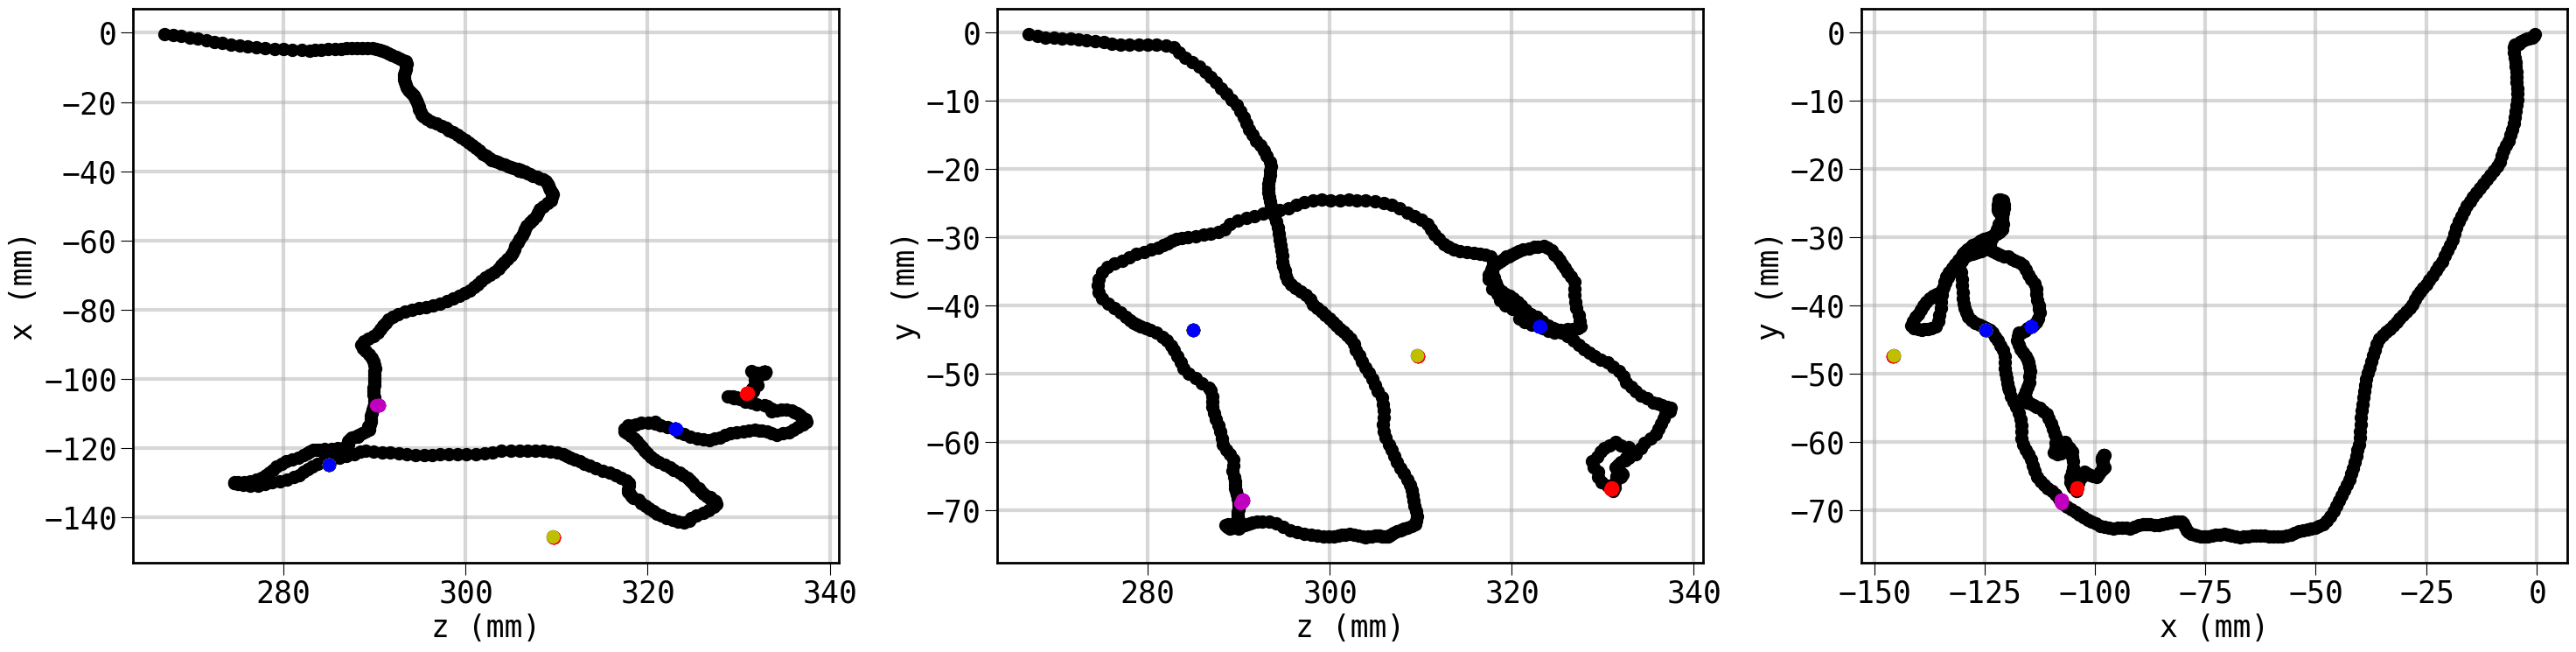

In [10]:
plt.figure(figsize=(30, 8))
for particle, hits in event_hits.groupby(level=0):
    plt.subplot(1, 3, 1); plt.plot(hits.z, hits.x, marker=".", ms=20); plt.xlabel("z (mm)"); plt.ylabel("x (mm)")
    plt.subplot(1, 3, 2); plt.plot(hits.z, hits.y, marker=".", ms=20); plt.xlabel("z (mm)"); plt.ylabel("y (mm)")
    plt.subplot(1, 3, 3); plt.plot(hits.x, hits.y, marker=".", ms=20); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

# Detsim

## Description

Reads energy deposits (hits) and produces true waveforms (TWF).

This city computes the photosensor hits of S1 and S2 signals from the MC hits. Each energy deposition produces a bunch of primary scintillation photons and a bunch of ionization electrons. The number of scintillation photons is used to estimate the photosensor hits in the S1 signal using the S1 Light Table (\*). The ionization electrons are drifted (with attachment) and diffused according to the input parameters. The resultin electron cloud is used to compute the sensor hits using S2 Light Tables and SiPM PSF (\*). The sensor hits are then sorted into buffers (like in Buffy) producing TWFs. TWFs do not contain any type of distortion or effect from the electronics.

(\*) The Light Tables and the PSF are input parameters to the city and they are obtained from custom MC simulations.

More details in the official documentation:
- Temporarily hosted in https://pr18-sw-docs.readthedocs.io/en/latest/detsim.html
- When the PR is approved: https://next-exp-sw.readthedocs.io/en/latest/detsim.html

## Parameters

| Parameter | Type |  SubParameter | Type | Description |
|:--------:|:--------:|:--------:|:--------:|:--------:|
| `s1_lighttable` | `Path` | | | File holding the S1 light table |
| `s2_lighttable` | `Path` | | | File holding the S2 light table |
| `sipm_psf` | `Path` | | | File holding the SiPM PSF |
| `buffer_params` | `dict` | | | Parameters that characterize the waveform buffer |
||| `pmt_width` | `float` | PMT sampling period (\*) |
||| `sipm_width` | `float` | SiPM sampling period (\*) |
||| `max_time` | `float` | Maximum time after start of the event. All responses after max_time are discarded. (\*\*,\*\*\*) |
||| `length` | `float` | Time span of the waveform. Same as `buffer_length` in Buffy (\*\*\*) |
||| `pre_trigger` | `float` | Trigger position (\*\*\*) |
||| `trigger_thr` | `float` | Threshold for trigger candidate selection in photoelectrons. Same as `trigger_threshold` in Buffy. |
| `physics_params` | `dict` | | | Parameters related to physical proceses |
||| `ws` | `float` | Average energy spent in the creation of a primary scintillation photon |
||| `wi` | `float` | Averare energy spent in the creation of a ionization electron |
||| `fano_factor` | `float` | Fano Factor: relative variance in the number of ionization electrons produced |
||| `conde_policarpo_factor` | `float` | Conde Policarpo Factor: relative variance in the EL light production |
||| `drift_velocity` | `float` | Electron drift velocity. Used to compute drift time from z. |
||| `lifetime` | `float` | Electron lifetime: drift time necessary for 1/e ionization electrons to survive |
||| `transverse_diffusion` | `float` | Diffusion in the x and y coordinated expressed in $[L]/[L]^{1/2}$ |
||| `longitufinal_diffusion` | `float` | Diffusion in the z coordinated expressed in $[L]/[L]^{1/2}$ |
||| `el_gain` | `float` | Number of secondary scintillation photons produced per ionization electron reaching the EL |
||| `el_drift_velocity` | `float` | Drift velocity within the EL gap. Controls the spread of the light pulse. |


(\*) Careful! Parameters in Diomira and Hypathia depend on this!

(\*\*) Must be greater than `length`.

(\*\*\*) Must satisfy be a multiple of 1 $\mu$s

## Configuration

A typical Detsim configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [11]:
config_file = "config_files/detsim.conf"

In [12]:
!cat $config_file

event_range = all
compression = "ZLIB4"
print_mod   = 1

detector_db = "new"
run_number  = -6400

s1_lighttable = "$ICDIR/database/test_data/NEXT_NEW.energy.S1.PmtR11410.LightTable.h5"
s2_lighttable = "$ICDIR/database/test_data/NEXT_NEW.energy.S2.PmtR11410.LightTable.h5"
sipm_psf      = "$ICDIR/database/test_data/NEXT_NEW.tracking.S2.SiPM.LightTable.h5"

physics_params = dict(ws                     = 39.2 * eV,
                      wi                     = 22.4 * eV,
                      fano_factor            = 0.15,
                      conde_policarpo_factor = 1.00,
                      drift_velocity         = 1.00 * mm / mus,
                      lifetime               = 12 * ms,
                      transverse_diffusion   = 1.20 * mm / cm**0.5,
                      longitudinal_diffusion = 0.30 * mm / cm**0.5,
                      el_gain                = 365,
                      el_drift_velocity      = 2.5 * mm / mus)


buffer_params = dict(pmt_width   =   1 * ns, # c

## City execution

In [13]:
output_file = replace_tag(input_file, "nexus", "detsim")
output_file

'data/HEe_fastsim.detsim.h5'

In [14]:
!city detsim $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 1
events processed: 2, event number: 2
events processed: 3, event number: 3
events processed: 4, event number: 4
events processed: 5, event number: 5
events processed: 6, event number: 6
events processed: 7, event number: 7
events processed: 8, event number: 8
events processed: 9, event number: 9


## Output

True waveforms for PMTs and SiPMs. Stored in the output file in the nodes
- `/pmtrd`
- `/sipmrd`

These are homogeneous arrays with shape (number of events, number of sensors, number of buffer samples), where the number of buffer samples is calculated from the ratio of `length` to the sensor sampling time included in the nexus file (possibly different for PMTs and SiPMs).

In [15]:
!ptdump -v $output_file:/pmtrd
!ptdump -v $output_file:/sipmrd

/pmtrd (EArray(10, 12, 800000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 524288)
/sipmrd (EArray(10, 1792, 800)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 327, 800)


### TWF visualization

<span class="burk">Careful with reading the entire `pmtrd` or `sipmrd` nodes of a large file in a single go, you might run out of memory!</span>

Note that the PMT is sampled at a much higher rate than the SiPM and therefore the number of photons per sample is much lower.

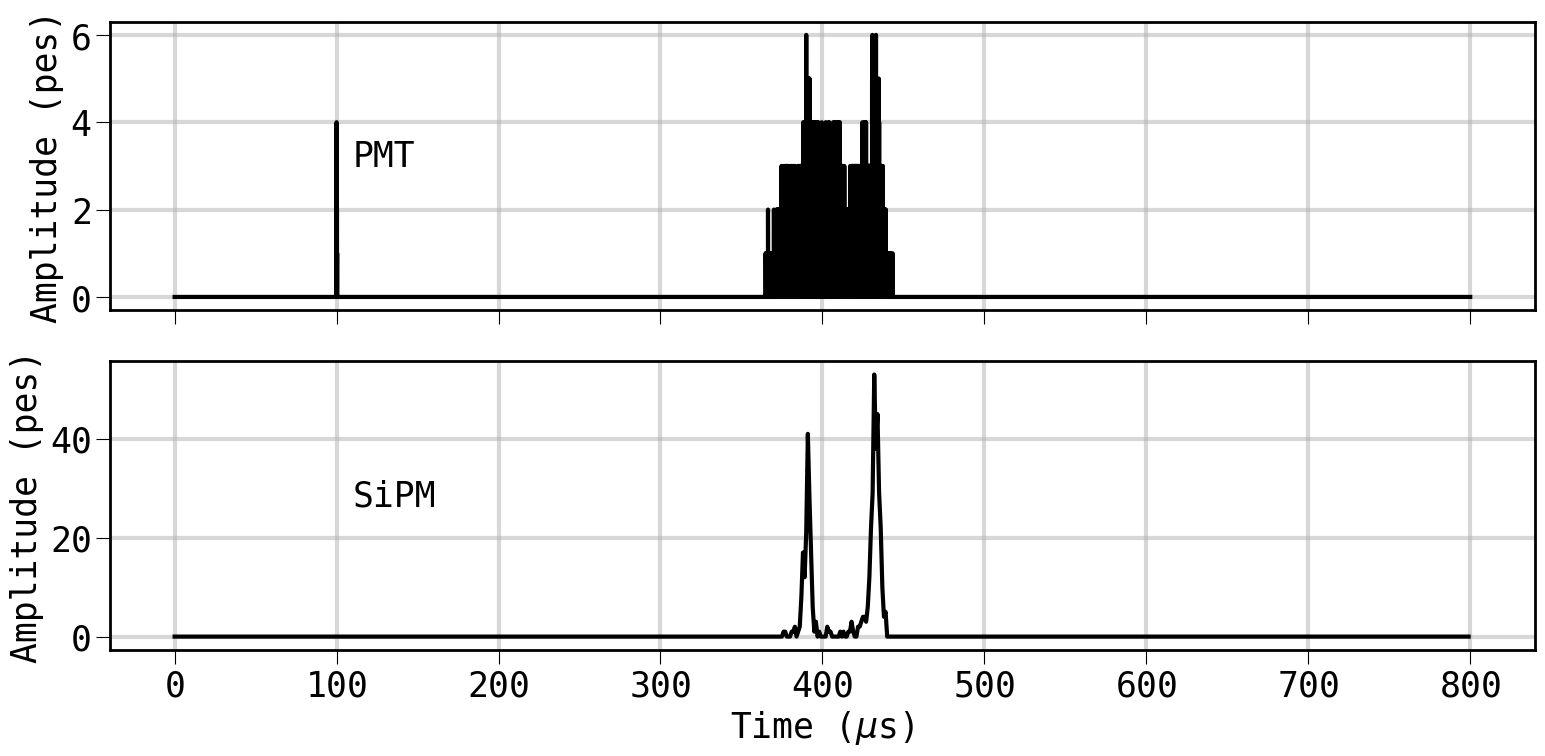

In [16]:
event_number = 0
with tb.open_file(output_file) as file:
    wf_pmt  = find_highest_wf(file.root. pmtrd, event_number)
    wf_sipm = find_highest_wf(file.root.sipmrd, event_number)

    sp_pmt  = 1e-3 # sampling period in mus
    sp_sipm = 1    # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
    ax1.plot(t_pmt , wf_pmt ); ax1.text(110, wf_pmt .max()/2, "PMT" );                                 ax1.set_ylabel("Amplitude (pes)")
    ax2.plot(t_sipm, wf_sipm); ax2.text(110, wf_sipm.max()/2, "SiPM"); ax2.set_xlabel("Time ($\mu$s)");ax2.set_ylabel("Amplitude (pes)")

# Notes

(1) the `loc` method can also select multiple indices at once using lists. This introduces a perhaps surprising behaviour: `.loc[(a,b,c)]` (with a tuple) and `.loc[[a,b,c]]` (with a list or an array) have different meanings. The former indexes a single row passing (or a group of them if the index has more levels) a single multi-index while the latter selects all the rows for which the first level of the index is either `a`, `b`, or `c`.

(2) Event numbers in MC are sequential starting at 0. For large productions (with more than one file), each file starts at a different event offset to prevent event id duplicates.